In [121]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import gensim
import nltk
import random
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk.stem import *
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora, models
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, Ridge, Lasso
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [49]:
df_wine = pd.read_csv('./wine-reviews/winemag-data-130k-v2.csv')
pd.set_option('max_rows', 5)

In [50]:
df_wine = df_wine.iloc[:,1:]
df_wine.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [51]:
# region_2 has a lot of null vales. So do Designation, taster_name, region_1
df_wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 13 columns):
country                  129908 non-null object
description              129971 non-null object
designation              92506 non-null object
points                   129971 non-null int64
price                    120975 non-null float64
province                 129908 non-null object
region_1                 108724 non-null object
region_2                 50511 non-null object
taster_name              103727 non-null object
taster_twitter_handle    98758 non-null object
title                    129971 non-null object
variety                  129970 non-null object
winery                   129971 non-null object
dtypes: float64(1), int64(1), object(11)
memory usage: 12.9+ MB


In [52]:
#description and reviews are the important columns; lets remove duplicates and NA in desccription
df_wine.drop_duplicates('description',inplace = True)
df_wine.dropna(subset=['description', 'price', 'points'], inplace = True)
df_wine.reset_index(inplace=True)

### Exploratory analysis
#### Visualization 1: Distribution of points

_Task_ :  **Discover, Present**; Targets: `Points`

_Visual encodings_ : **Single key** (count of `points` in a bin), axis orientation - **rectlinear**

_Marks_ : **Line**

_Position_ : **Vertical**

_Size_ : **Length** (gives counts for bins)

_Attributes_ : Counts - Quantative; Bins - categorical

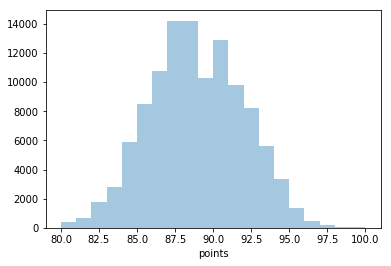

In [8]:
sns.distplot(df_wine.points, bins = 20, kde = False)

#### Visualization 2: Distribution of variety and points

This Visulaization is to observe the distribution of points across 10 most common varieties of wine. We observe that a few wines like syrah and pinot noir are rated better, and wines like Red Blend, Merlot have a lot of outliers. 

_Task_ : **Discover distributions**, extremes and skew

_Attributes_ : Data: Variety(categorical), points(quantitative); Derived: 5 quantitative attributes representing distribution of points for a category

_Visual Encodings_ : **1D allignment of glyphs** along horizontal axis

_Marks_ : **Line**

_Position_ : Qualitative is mapped to **horizontal** axis, Categorical to **vertical** axis

_Size_ : **Length** of the box plot, with 5 quantiles seperated by a vertical lines

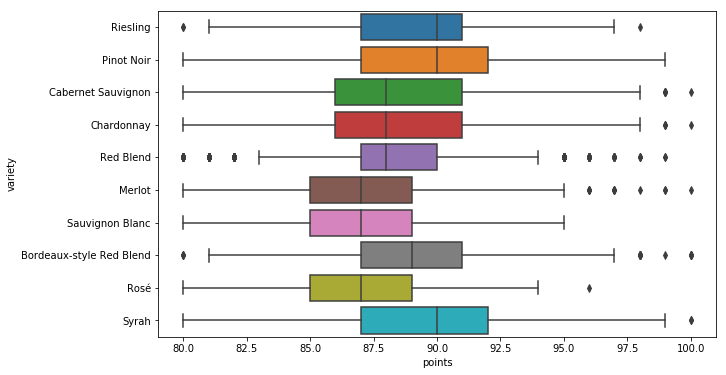

In [515]:
df_filtered = df_wine[df_wine.variety.isin(df_wine.variety.value_counts().head(10).index)]
plt.figure(figsize=(10,6))
s = sns.boxplot(
    y = 'variety',
    x = 'points',
    data = df_filtered)

#### Visualization 3: Correlation  - Wine ratings vs price

This visualization helps buyers understand the relationship between prices and ratings. I'm using a regression line to highlight the trend of the two variables. We observe a positive correlation between prices and points, i.e, more expensive wines are indeed better rated.  We also observe that there are a few outliers on the further left which shows some expensive wines are not well rated compared to others.

_Task_ : **Discover trends** of prices vs wine ratings

_Attributes_ : Data - log(price), points;

_Visual encodings_ : Regression line along **rectlinear** axis

_Marks_ : **Points** and **Line**

_Position_ : Both

_Color_ : Regression line is represented in blue, points in green

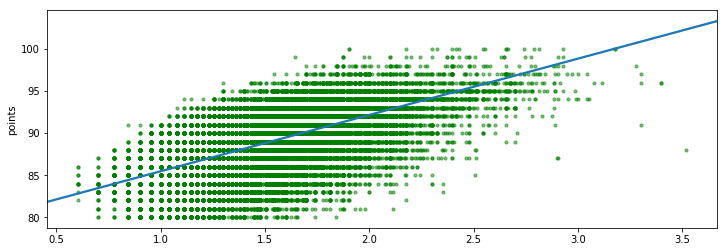

In [160]:
plt.figure(figsize = (12, 4))
sns.regplot(
    x = list(map(lambda x: math.log10(x), df_wine.price)),
    y = df_wine.points,
    scatter_kws = {'color': 'g', "s" : 10, "alpha" : 0.5})

#### Data Preprocessing

In [53]:
categorical = ['country', 'designation', 'province', 'region_1', 'region_2', 
               'title', 'variety', 'winery', 'taster_name', 'taster_twitter_handle']

In [54]:
for col in categorical:
    print(col, "; NA counts: ", df_wine.loc[:,col].isna().sum(),
          "; Unique counts: ", len(df_wine.loc[:,col].unique()))

country ; NA counts:  55 ; Unique counts:  43
designation ; NA counts:  32050 ; Unique counts:  35773
province ; NA counts:  55 ; Unique counts:  423
region_1 ; NA counts:  18011 ; Unique counts:  1205
region_2 ; NA counts:  65008 ; Unique counts:  18
title ; NA counts:  0 ; Unique counts:  110612
variety ; NA counts:  1 ; Unique counts:  698
winery ; NA counts:  0 ; Unique counts:  15854
taster_name ; NA counts:  23268 ; Unique counts:  20
taster_twitter_handle ; NA counts:  27751 ; Unique counts:  16


We will consider country, province and variety for categorical attributes owing to their resonable unique and NA counts, and drop the rest

In [55]:
one_hot_cols = ['country', 'province', 'variety']
dummies = pd.get_dummies(df_wine[one_hot_cols])
df_wine = df_wine.drop(columns = categorical)
data = pd.concat([df_wine, dummies], axis = 1)
data.reset_index(inplace = True)

In [56]:
data.shape

(111567, 1166)

### LDA
#### Preprocessing : Lemmatize, remove stop words

In [57]:
nltk.download('wordnet')
#stem, lemmatize data
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token)>3:
            _tokens = WordNetLemmatizer().lemmatize(token, pos = 'v')
            result.append(_tokens)
    return result

[nltk_data] Downloading package wordnet to /home/d/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [58]:
def do_call(doc_raw):
    doc_preprocessed = []
    for i,line in enumerate(doc_raw):
        doc_preprocessed.append(preprocess(line))
        
    return doc_preprocessed

In [59]:
%%time
doc_preprocessed = do_call(data.description)

CPU times: user 22.5 s, sys: 173 ms, total: 22.6 s
Wall time: 22.6 s


In [60]:
doc_preprocessed[1]

['tart',
 'snappy',
 'flavor',
 'lime',
 'flesh',
 'rind',
 'dominate',
 'green',
 'pineapple',
 'poke',
 'crisp',
 'acidity',
 'underscore',
 'flavor',
 'wine',
 'stainless',
 'steel',
 'ferment']

#### TF-IDF

In [61]:
#get dictionary for reviews 
def get_dict(doc):
    return gensim.corpora.Dictionary(doc)

#convert dictionary to bag-of-words model
def generate_bow(doc_list):
    doc_dict = get_dict(doc_list)
    doc_bow = [doc_dict.doc2bow(line) for line in doc_list]
    return doc_bow, doc_dict

In [62]:
%%time
doc_bow, doc_dict = generate_bow(doc_preprocessed)

CPU times: user 8.66 s, sys: 113 ms, total: 8.77 s
Wall time: 8.79 s


In [63]:
%%time
tfidf = models.TfidfModel(doc_bow)
doc_tfidf = tfidf[doc_bow]

CPU times: user 950 ms, sys: 35.9 ms, total: 986 ms
Wall time: 985 ms


In [64]:
def run_lda(n_topics, doc_tfidf):
    doc_lda = gensim.models.LdaMulticore(doc_tfidf, num_topics = n_topics, id2word = doc_dict,
                                         passes = 3, minimum_probability=0.0)
    for i, t in doc_lda.print_topics(-1):
        print('Topic: {} Word: {} '.format(i,t))
        
    doc_topic_dist_tup = doc_lda.get_document_topics(doc_tfidf, minimum_probability=0.0)
    doc_topic_prob = np.zeros(shape= (len(doc_topic_dist_tup), n_topics), dtype = "float64")
    for i, top_dist in enumerate(doc_topic_dist_tup):
        doc_topic_prob[i,:] = np.asarray(top_dist)[:,1]
        
    return doc_lda, doc_topic_prob

In [65]:
%%time
n_topics = 10
_, doc_topic_prob = run_lda(n_topics, doc_tfidf)

Topic: 0 Word: 0.008*"cherries" + 0.007*"blackberry" + 0.007*"cherry" + 0.006*"pinot" + 0.006*"sweet" + 0.006*"good" + 0.006*"flavor" + 0.006*"cola" + 0.006*"pair" + 0.006*"rich" 
Topic: 1 Word: 0.003*"win" + 0.003*"trail" + 0.003*"years" + 0.002*"blackberry" + 0.002*"vineyard" + 0.002*"wine" + 0.002*"track" + 0.002*"fruit" + 0.002*"winery" + 0.002*"decanter" 
Topic: 2 Word: 0.011*"apple" + 0.010*"peach" + 0.010*"white" + 0.009*"citrus" + 0.008*"pear" + 0.008*"lemon" + 0.007*"lime" + 0.007*"aromas" + 0.006*"chardonnay" + 0.006*"pineapple" 
Topic: 3 Word: 0.016*"wine" + 0.014*"structure" + 0.013*"wood" + 0.013*"age" + 0.013*"drink" + 0.012*"fruit" + 0.012*"ripe" + 0.011*"tannins" + 0.011*"acidity" + 0.011*"rich" 
Topic: 4 Word: 0.013*"black" + 0.012*"cherry" + 0.011*"tannins" + 0.011*"palate" + 0.010*"alongside" + 0.010*"aromas" + 0.009*"dry" + 0.009*"offer" + 0.008*"pepper" + 0.008*"berry" 
Topic: 5 Word: 0.009*"feel" + 0.008*"finish" + 0.008*"taste" + 0.007*"flavor" + 0.007*"green" + 

In [66]:
topics = ['topic_'+str(i) for i in range(1, 11)]
doc_lda = pd.DataFrame(doc_topic_prob, columns=topics)

In [71]:
doc_lda.reset_index(inplace=True)
data = data.iloc[:,2:]
data = data.drop(columns=['description'])

In [113]:
parsed_data = pd.concat([doc_lda, data], axis = 1)
parsed_data = parsed_data.iloc[:,1:]

In [370]:
del doc_bow, doc_dict, doc_lda_filt, doc_preprocessed

#### Train-test split

In [115]:
#test and train split
train = parsed_data.sample(frac=0.8, random_state = 10)
test = parsed_data.drop(train.index)
train.price = StandardScaler().fit_transform(train.price.values.reshape(-1,1))

In [116]:
#model fitting

In [117]:
#grid search CV
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score

In [118]:
X = train.iloc[:, train.columns!='points']
y = train.points
cv = 10
scoring = {'mse': make_scorer(mean_squared_error),
          'r2' : make_scorer(r2_score)}

#### Grid Search CV

Using gridsearchcv for hyperparameter tuning using 10 fold cross-validation. Gridsearch returns the estimators of best performing model and the results for all 10 folds of CV. Since gridsearch returns the best model, I chose this library.

In [125]:
def call_gridsearch(clf, param_grid, scoring, filename):
    gs = GridSearchCV(clf, cv = cv, param_grid=param_grid, scoring=scoring, 
                      verbose = 5, refit = 'r2', n_jobs = -1)
    gs.fit(X, y)
    cv_results = pd.DataFrame(gs.cv_results_)
    cv_results.to_pickle(filename)
    return cv_results, gs

#### Ridge Regression

In [130]:
clf_ridge = Ridge(random_state=10)
params = {'alpha' : [0.1, 0.01, 0.001, 1, 10]}
cv_ridge, gs_ridge = call_gridsearch(clf_ridge, params, scoring, 'ridge')

Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] alpha=0.1 .......................................................
[CV] alpha=0.1 .......................................................
[CV] alpha=0.1 .......................................................
[CV] alpha=0.1 .......................................................
[CV]  alpha=0.1, mse=5.900769875997822, r2=0.3905695576110847, total=  45.3s
[CV] alpha=0.1 .......................................................
[CV]  alpha=0.1, mse=5.9251320869846555, r2=0.3740513383070646, total=  47.8s
[CV] alpha=0.1 .......................................................
[CV]  alpha=0.1, mse=5.991067996883995, r2=0.36619496572648413, total=  48.9s
[CV] alpha=0.1 .......................................................
[CV]  alpha=0.1, mse=5.870849986901589, r2=0.3909524535858526, total=  49.9s
[CV] alpha=0.1 .......................................................
[CV]  alpha=0.1, mse=7.151399517259481, r2=0.25690381849886, 

[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.7min


[CV] alpha=0.01 ......................................................
[CV]  alpha=0.01, mse=5.903489727058857, r2=0.3902886518868841, total=  51.9s
[CV] alpha=0.01 ......................................................
[CV]  alpha=0.01, mse=5.927252356449047, r2=0.37382734670414663, total=  52.4s
[CV] alpha=0.01 ......................................................
[CV]  alpha=0.01, mse=5.993329080545628, r2=0.36595576193036605, total=  53.4s
[CV] alpha=0.01 ......................................................
[CV]  alpha=0.01, mse=5.874914942846504, r2=0.3905307512003283, total=  53.0s
[CV] alpha=0.01 ......................................................
[CV]  alpha=0.01, mse=7.154658042159614, r2=0.25656522779297497, total=  54.4s
[CV] alpha=0.01 ......................................................
[CV]  alpha=0.01, mse=5.821179967761129, r2=0.4000656511567303, total=  55.4s
[CV] alpha=0.01 ......................................................
[CV]  alpha=0.01, mse=5.93238824

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 11.3min finished
/home/d/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_mse'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/d/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_mse'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/d/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_mse'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_ar

In [151]:
print('Best model: ', gs_ridge.best_estimator_, '\nBest r2 Score:', gs_ridge.best_score_)

Best model:  Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=10, solver='auto', tol=0.001) 
Best r2 Score: 0.3749389137142834


In [172]:
i = gs_ridge.best_index_
r2_ridge= cv_ridge.iloc[i,6:]

#### Random Forest regression

In [140]:
%%time
clf_gbrt =  GradientBoostingRegressor(random_state=100)
param_gbrt = {'n_estimators': [50, 70, 100, 150, 200]}
cv_gbrt, gs_gbrt = call_gridsearch(clf_gbrt, param_gbrt, scoring, 'rf')

Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] n_estimators=50 .................................................
[CV] n_estimators=50 .................................................
[CV] n_estimators=50 .................................................
[CV] n_estimators=50 .................................................
[CV]  n_estimators=50, mse=3.9700937060572037, r2=0.5881387131159683, total= 4.8min
[CV] n_estimators=50 .................................................
[CV]  n_estimators=50, mse=3.947605479552942, r2=0.5829631592102831, total= 4.9min
[CV] n_estimators=50 .................................................
[CV]  n_estimators=50, mse=3.9612437272564787, r2=0.5908834664215733, total= 4.9min
[CV] n_estimators=50 .................................................
[CV]  n_estimators=50, mse=3.904051181387348, r2=0.5869839410749922, total= 5.0min
[CV] n_estimators=50 .................................................
[CV]  n_estimators=50, mse=3.94637772

[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 14.7min


[CV]  n_estimators=70, mse=3.842096863241421, r2=0.6031889329237168, total= 5.9min
[CV] n_estimators=70 .................................................
[CV]  n_estimators=70, mse=3.8370010995918244, r2=0.5946477364648759, total= 6.0min
[CV] n_estimators=70 .................................................
[CV]  n_estimators=70, mse=3.866445103524017, r2=0.5988913174582585, total= 5.9min
[CV] n_estimators=70 .................................................
[CV]  n_estimators=70, mse=3.7886146562021765, r2=0.5991961628089897, total= 6.1min
[CV] n_estimators=70 .................................................
[CV]  n_estimators=70, mse=3.83488448690047, r2=0.6015202322515834, total= 6.1min
[CV] n_estimators=70 .................................................
[CV]  n_estimators=70, mse=3.8181318922292378, r2=0.6065010043928838, total= 6.0min
[CV] n_estimators=70 .................................................
[CV]  n_estimators=70, mse=3.8063926765139544, r2=0.60541184153028, total=

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 113.9min finished


CPU times: user 7min 14s, sys: 3.65 s, total: 7min 17s
Wall time: 2h 43s


/home/d/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_mse'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/d/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_mse'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/d/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_mse'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/d/anaconda3/lib/python3.6/site-packages/sklear

In [153]:
print('Best Model: ', gs_gbrt.best_estimator_, '\nBest Score: ', gs_gbrt.best_score_)

Best Model:  GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, presort='auto', random_state=100,
             subsample=1.0, verbose=0, warm_start=False) 
Best Score:  0.6226468488483902


In [173]:
i = gs_gbrt.best_index_
r2_gbrt = cv_gbrt.iloc[i,6:]

#### Lasso Regression

In [131]:
%%time
clf_lasso = Lasso(random_state=100)
param_lasso = {'alpha' :[0.1, 0.01, 0.001, 1, 10]}
cv_lasso, gs_lasso = call_gridsearch(clf_lasso, param_lasso, scoring, 'lasso')

Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] alpha=0.1 .......................................................
[CV] alpha=0.1 .......................................................
[CV] alpha=0.1 .......................................................
[CV] alpha=0.1 .......................................................
[CV]  alpha=0.1, mse=7.267548775777033, r2=0.24940888077661882, total=   5.1s
[CV] alpha=0.1 .......................................................
[CV]  alpha=0.1, mse=7.102813247207671, r2=0.24963758088858146, total=   6.3s
[CV] alpha=0.1 .......................................................
[CV]  alpha=0.1, mse=7.168295012308759, r2=0.25635427596344695, total=   7.0s
[CV] alpha=0.1 .......................................................
[CV]  alpha=0.1, mse=7.430024577811739, r2=0.21396535899069713, total=   6.9s
[CV] alpha=0.1 .......................................................
[CV]  alpha=0.1, mse=8.894603050521042, r2=0.07576893909243

[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   31.2s


[CV]  alpha=0.01, mse=6.239049926661211, r2=0.35563205534282816, total=  13.6s
[CV]  alpha=0.01, mse=6.167512088732654, r2=0.34844559053840995, total=  13.1s
[CV] alpha=0.01 ......................................................
[CV] alpha=0.01 ......................................................
[CV]  alpha=0.01, mse=6.182200695448432, r2=0.35865263575064354, total=  10.7s
[CV] alpha=0.01 ......................................................
[CV]  alpha=0.01, mse=6.40238145157729, r2=0.3226814321821093, total=  12.1s
[CV] alpha=0.01 ......................................................
[CV]  alpha=0.01, mse=6.145294322061106, r2=0.36666222862476916, total=  12.7s
[CV] alpha=0.01 ......................................................
[CV]  alpha=0.01, mse=7.7296390470880745, r2=0.19681941326158914, total=  13.8s
[CV] alpha=0.01 ......................................................
[CV]  alpha=0.01, mse=6.455524346054696, r2=0.34768377358389413, total=  14.0s
[CV] alpha=0.001 .....

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  6.8min finished


CPU times: user 1min 19s, sys: 1.93 s, total: 1min 21s
Wall time: 7min 23s


/home/d/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_mse'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/d/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_mse'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/d/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_mse'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/d/anaconda3/lib/python3.6/site-packages/sklear

In [152]:
print('Best Model: ', gs_lasso.best_estimator_, '\nBest r2 score: ', gs_lasso.best_score_)

Best Model:  Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=100,
   selection='cyclic', tol=0.0001, warm_start=False) 
Best r2 score:  0.3652085693035785


In [162]:
i = gs_lasso.best_index_
r2_lasso = cv_lasso.iloc[i,6:]

In [167]:
mse_test_cols = ['split'+str(i)+'_test_mse' for i in range(0,10)]
mse_train_cols = ['split'+str(i)+'_train_mse' for i in range(0,10)]
r2_test_cols = ['split'+str(i)+'_test_r2' for i in range(0,10)]
r2_test_cols = ['split'+str(i)+'_train_r2' for i in range(0,10)]

In [226]:
models_r2 = pd.concat([r2_ridge[r2_test_cols], r2_lasso[r2_test_cols], r2_gbrt[r2_test_cols]], axis=1)
models_mse = pd.concat([r2_ridge[mse_test_cols], r2_lasso[mse_test_cols], r2_gbrt[mse_test_cols]], axis=1)
models_r2.columns = ['ridge', 'lasso', 'gbrt']
models_mse.columns = ['ridge', 'lasso', 'gbrt']
models_r2['fold'] = pd.Series(np.arange(1,11), index = models_r2.index)
models_mse['fold'] = pd.Series(np.arange(1,11), index = models_mse.index)

In [227]:
models = models_r2.melt(id_vars=['fold'])
models_r2.reset_index(inplace=True)

### Visualization 3: 
r2 values on test folds for best performing models, we see the performance of GBRYT are much higher than the other two moels.

_Task_ : Discover

_Marks_ : Points

_Attributes_ : r2 score - qunatitative, fold - categorical

_position_ : both

_color_ : Colored by model

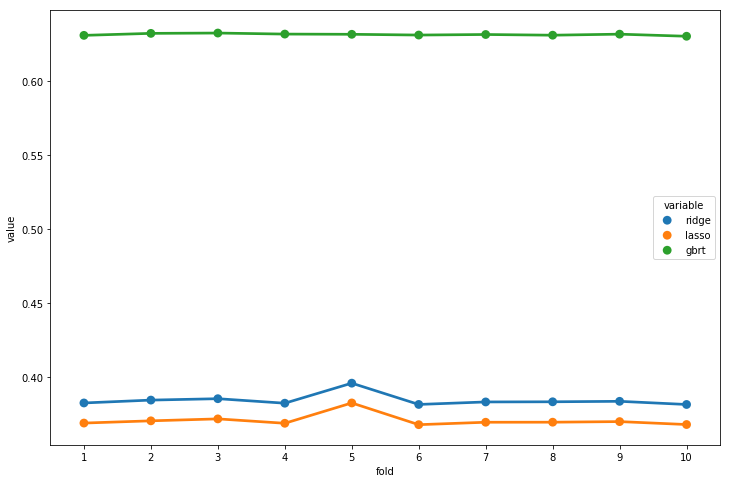

In [228]:
plt.figure(figsize=(12,8))
sns.pointplot(y = "value", x = "fold", hue = "variable", data = models)

In [229]:
models = models_mse.melt(id_vars=['fold'])
models_mse.reset_index(inplace=True)

mse values of best performing models

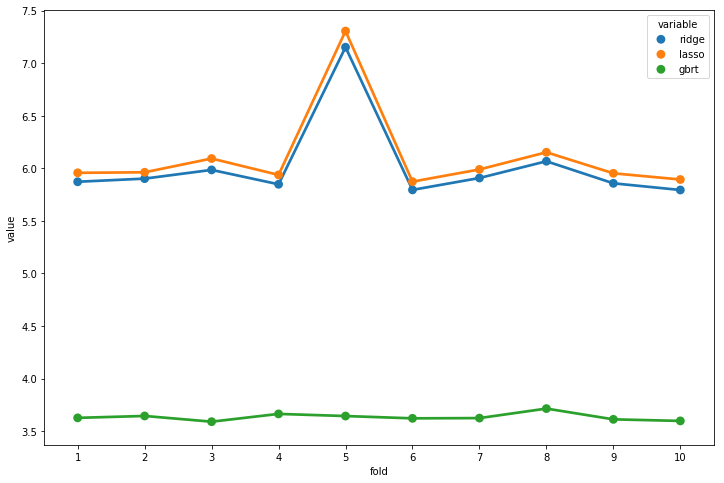

In [230]:
plt.figure(figsize=(12,8))
sns.pointplot(y = "value", x = "fold", hue = "variable", data = models)

### Best model!

As seen above the best model is Gradient Boosted Regression Trees

In [305]:
clf = gs_gbrt.best_estimator_

In [306]:
features = np.where(clf.feature_importances_!=0)

In [307]:
feature_names = X.columns[features]

In [308]:
feature_imp = clf.feature_importances_[clf.feature_importances_!=0]

In [309]:
feature_imp = pd.DataFrame(feature_imp, index=feature_names)
feature_imp.columns = ['importance']

In [313]:
feature_imp = feature_imp.sort_values(by = ['importance'], ascending= False)
feature_imp = feature_imp[0:25]

We see that `price` is the most important feature to make the predictions; also Topic - 6 which contains words like "crisp", "fruity", "attractive", "soft", and topic - 4 having words like "black", "Dry" are important.

_Task_ : Analyze 

_Marks_ : Line

_Attributes_ : feature score - qunatitative, Feature name - categorical

_position_ : horizontal

_size_ : Lenght of line indicates the feature importance

_color_ : Saturation increases with importance

(array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16]),
 <a list of 9 Text xticklabel objects>)

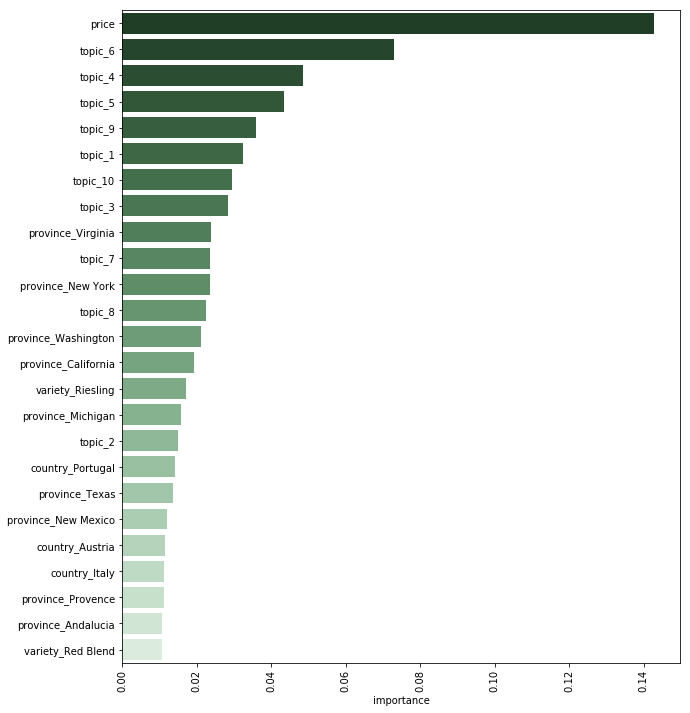

In [336]:
plt.figure(figsize=(10,12))
s = sns.barplot(y = feature_imp.index, x = 'importance', data = feature_imp, palette=sns.cubehelix_palette(25, start=2, rot=0, dark=0.2, light=.90, reverse=True))
plt.xticks(rotation = 90)

### Predicting on test set

In [339]:
std = StandardScaler()
std.fit(train.price.values.reshape(-1,1))
test.price = std.transform(test.price.values.reshape(-1,1))

In [341]:
clf.fit(X,y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, presort='auto', random_state=100,
             subsample=1.0, verbose=0, warm_start=False)

In [342]:
pred = clf.predict(test.iloc[:, test.columns!='points'])

In [346]:
print("R2 score: ", r2_score(test.points, pred))

R2 score:  0.5185340237112
